In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(data.table)
library(lme4)
library(arm)
library(caret)
library(MLmetrics)
library(rstanarm)
library(loo)
library(rstan)
library(ROCR)
library(circular)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



arm (Version 1.11-2, built: 2020-7-27)


Workin

In [2]:
# load data
data <- read.csv("../input/riiid-test-answer-prediction/train.csv", header = T, na.strings = c("","NA"), nrows = 2000000)

In [3]:
# use a 10000 subset for model fit
data1 <- data.frame(sample_n(data, size=10000))

In [6]:
# only keep data with 'question' type 
question <- data1 %>% filter(content_type_id == 0)

# get user-level question count
ques_num <- as.data.frame(table(question$user_id))

colnames(ques_num) <- c("user_id","ques_num")

# get user-level correct question count
try <- question %>% group_by(user_id) %>% dplyr::summarise(correct_num = sum(answered_correctly))

`summarise()` ungrouping output (override with `.groups` argument)



In [7]:
# user-level interaction count
df <- data.frame(table(data1$user_id))
colnames(df)<- c("user_id","inter_num")

In [8]:
result <- merge(ques_num,try, by="user_id")

# calculate user-level correct rate
result$correctRate <- result$correct_num / result$ques_num


result <- merge(df,result,by="user_id")
result$lec_num <- result$inter_num - result$ques_num
result <- result[order(-result$inter_num),]

In [9]:
# create grouping variable 'lec'
result$lec <- ifelse(result$lec_num > 0, 1, 0)
result$lec <- factor(result$lec)

In [10]:
# do same thing for question-level
ques_num2 <- data.frame(table(question$content_id))
colnames(ques_num2) <- c("content_id","ques_num")
try2 <- question %>% group_by(content_id) %>% dplyr::summarise(correct_num = sum(answered_correctly))

`summarise()` ungrouping output (override with `.groups` argument)



In [11]:
result2 <- merge(ques_num2, try2, by="content_id")
result2$correctRate <- result2$correct_num / result2$ques_num
result2$false_num <- result2$ques_num - result2$correct_num
result2 <- result2 %>% relocate(false_num, .before = correctRate)

In [12]:
data2 <- data1 %>% dplyr::select("timestamp","user_id","content_id","content_type_id","answered_correctly","prior_question_elapsed_time","prior_question_had_explanation")

In [13]:
data2 <- merge(data2,result,by="user_id")

In [14]:
data2 <- merge(data2,result2,by="content_id")

In [15]:
colnames(data2)[9:11] <- c("userQuesNum","userCorrectNum","userCorrectRate")
colnames(data2)[14:15] <- c("quesNum","quesCorrectNum")
colnames(data2)[17] <- "quesCorrectRate"

In [16]:
data2$content_id <- factor(data2$content_id)
data2$user_id <- factor(data2$user_id)

In [17]:
data2$experience <- ifelse(data2$userQuesNum >= 50, "True", "False")
data2$experience <- factor(data2$experience)

In [18]:
data3 <- data2 %>% filter(content_type_id == '0')

In [19]:
ques <- read.csv("../input/riiid-test-answer-prediction/questions.csv",header=TRUE, na.strings = c("","NA")) # read question.csv

# split tags
for (i in 1:nrow(ques)){
    if (i == 1){
        tagCount <- cbind.data.frame("tag" = as.numeric(unlist(str_split(ques$tags[i], " "))))
    } else{
        tagCount <- rbind.data.frame(tagCount, cbind.data.frame("tag" = as.numeric(unlist(str_split(ques$tags[i], " ")))))
    }
}

# create dataframe with tag and its count
tc <- data.frame(table(tagCount$tag))
colnames(tc) <- c("tag","count")
tc1 <- arrange(tc,desc(count))[1:20,]

# top 20 tags
hot_tag <- tc1$tag

# filter out NA
ques <- ques %>% filter(tags != 'NA')

In [20]:
ques$hot <- 0

# create grouping variable for hot tag
for(i in 1:nrow(ques)){
    tag_row <- as.numeric(unlist(str_split(ques$tags[i], " ")))
    length <- length(tag_row)
    for(j in 1:length) {
        for(k in 1:length(hot_tag)){
            if (tag_row[j] == hot_tag[k]) {
                ques$hot[i] <- 1
            } 
        }
    }

}

In [21]:
ques_temp <- ques[,c(1,6)]
colnames(ques_temp)[1] <- c("content_id")

In [22]:
data3 <- merge(data3, ques_temp, by = "content_id")

In [23]:
data3$hot <- factor(data3$hot)

In [24]:
data4 <- data3[,-c(4,8,16)]

In [25]:
data4 <- data4 %>% filter(prior_question_elapsed_time != 'NA') %>% filter (prior_question_had_explanation != 'NA')

In [28]:
data5 <- data4[,-c(1,2)]

In [29]:
#length(unique(data4$content_id))

[1] 5330

In [30]:
#length(unique(data4$user_id))

[1] 2699

# Model

**First I tried logistic regression.**

In [38]:
f <- stan_glm(answered_correctly~ ., family="binomial", algorithm="optimizing", data = data5,refresh = 0)

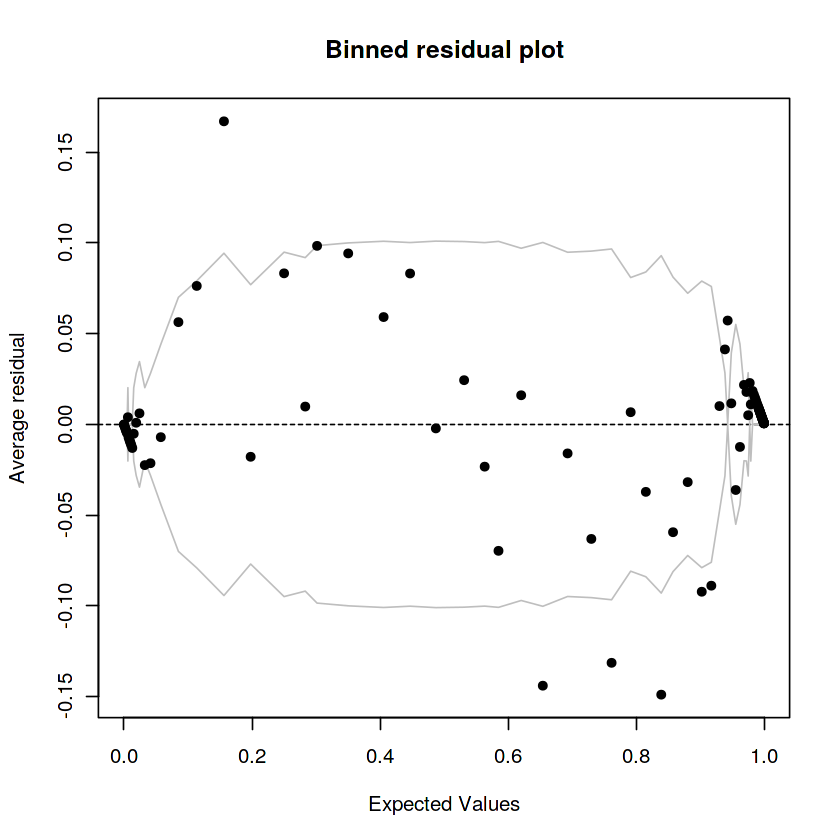

In [39]:
binnedplot(fitted(f),resid(f,type="response"))

In [37]:
loo1 <- loo(f)

In [ ]:
f3 <- stan_glm(answered_correctly ~ timestamp + prior_question_elapsed_time + prior_question_had_explanation +
          userQuesNum +  userCorrectRate + lec + lec_num + quesNum + quesCorrectRate + 
          experience + hot, family="binomial", algorithm="optimizing", data = data5, refresh = 0)

In [ ]:
binnedplot(fitted(f3),resid(f3,type="response"))

In [ ]:
loo3 <- loo(f3)

In [ ]:
loo_compare(loo1,loo3)

In [ ]:
f5 <- stan_glmer(formula = answered_correctly ~ timestamp + prior_question_elapsed_time + 
                        userQuesNum + userCorrectNum + userCorrectRate + prior_question_had_explanation + 
                        quesNum + quesCorrectNum + quesCorrectRate + lec_num + lec + experience + hot + (1 | content_id),
                        data = data4, family = binomial, refresh = 0)

In [ ]:
binnedplot(fitted(f5),resid(f5,type="response"))

In [ ]:
loo5 <- loo(f5)

In [ ]:
loo_compare(loo1,loo5)

In [ ]:
fitted.y = fitted(f); observed.y= f$y
perf<- performance(prediction(fitted.y,observed.y) ,"tpr","fpr")
plot(perf); abline(0,1,lty=2)

In [ ]:
auc<- performance(prediction(fitted.y,observed.y) ,"auc") # AUC
auc@y.values[[1]]

In [ ]:
binnedplot(data5$userCorrectRate,resid(f,type="response"))